# MHW Spatial Detection & Tracking

Marine heatwave events are a specific type of extreme event that occurs when ocean temperatures exceed a threshold set based on long-term temperature patterns. Typically a marine heatwave event is determined when temperatures exceed the 90th percentile of temperatures for that day based on a 30-year climatology.

Existing python and R libraries do a great job of determining when these events occur and how long they persist for single timeseries, that could represent a point in space or an average over some area.

While this is helpful for communicating the severity of events through time, it obscures that heat stresses are distributed unequally through space and that there is an opportunity to track the event spatially as well.

To track events spatially there is a need to provide heatwave threshold detection functions that observe them in space using xarray. Once an xr.Dataset exists that can track them spatially, we can transition to using ocetrac to identify clusters of adjacent cells as a spatially distinct event, & follow them spatially.

This approach closely follows the example provided by the python library [ocetrac](https://github.com/ocetrac/ocetrac), and would not be possible without their pioneering work.

**Steps:**
 - load sst and anomaly information
 - subset reference period for threshold creation
 - make quantile dataset that contains threshold for MHW
 - use quantile dataset to flag events
 - use some other function to do a rolling test to track event length and check for breaks

In [1]:
# Import libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os
import oisstools as ot
import dask


# Set the workspace - local/ docker
workspace = "local"
box_root = ot.set_workspace(workspace)
print(f"Working via {workspace} directory at: {box_root}")

Working via local directory at: /Users/akemberling/Library/CloudStorage/Box-Box/


In [2]:
# Load SSt for a reference period that matches our climatology

# Set start and end year of data to load
start_year = 1981
end_year = 2021

#Generate list of file names from start and end + 1
my_years = np.arange(start_year, (end_year + 1), 1)
   

# Make List of the Corresponding File Names:
sst_files = []
anom_files = []
for i in my_years:
    sst_files.append(f"{box_root}RES_Data/OISST/oisst_mainstays/annual_observations/sst.day.mean.{i}.v2.nc")
    anom_files.append(f"{box_root}RES_Data/OISST/oisst_mainstays/annual_anomalies/1982to2011_climatology/daily_anoms_{i}.nc")

    

# Use open_mfdataset to load and append the list of oisst arrays
sst = xr.open_mfdataset(sst_files, parallel = True, combine = "by_coords", chunks = {"lat" : 45, "lon" : 90, "time" : -1})
anoms = xr.open_mfdataset(anom_files, parallel = True, combine = "by_coords", chunks = {"lat" : 45, "lon" : 90, "time" : -1})
print(f"OISST data and anomalies loaded for {start_year} through {end_year}")

OISST data and anomalies loaded for 1981 through 2021


In [3]:
# Pull Data for use as a climate reference period

# Print Climatology Years
ref_start = "1982-01-01"
ref_end = "2011-12-31"
print(f"Generating Climatology for the Following Range: {ref_start} to {ref_end}")


# Pull data for just that period
# Thresholds will come from here
ref_period = sst.sel(time = slice(ref_start, ref_end))

Generating Climatology for the Following Range: 1982-01-01 to 2011-12-31


## Set up the leap-year adjustment

In the other parts of this repo a modified ordinal date has been used for climatological estimation to preserve the position of leap year dates (Feb. 29th). This step adds this coordinate to each xr.Dataset so that they can be grouped and matched up correctly using that coordinate.

In [4]:
# Make Day of year (or MOD) a dimension:
sst        = ot.add_mod(grid_obj = sst, time_dim = "time", out_coord = "modified_ordinal_day")
anoms      = ot.add_mod(grid_obj = anoms, time_dim = "time", out_coord = "modified_ordinal_day")
ref_period = ot.add_mod(grid_obj = ref_period, time_dim = "time", out_coord = "modified_ordinal_day")
ref_period

,Array,Chunk
Bytes,42.32 GiB,5.65 MiB
Shape,"(10957, 720, 1440)","(366, 45, 90)"
Count,28713 Tasks,7680 Chunks
Type,float32,numpy.ndarray


## Get MHW Thresholds from Reference Period

In [25]:
# Thank you to Dr. Hillary Scannell for code help with chunks:
# https://github.com/ocetrac/ocetrac/blob/main/docs/examples/cmip6.ipynb

# Rechunk time dim
if ref_period.chunks:
    ref_period = ref_period.chunk({'time': -1})


# Set MHW threshold
mhw_pct = .9
mcs_pct = .1

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, MOD: 366)
Coordinates:
  * lat                   (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.4 359.6 359.9
    quantile              float64 0.9
  * MOD                   (MOD) int64 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Data variables:
    sst                   (MOD, lat, lon) float64 dask.array<chunksize=(1, 45, 90), meta=np.ndarray>
    modified_ordinal_day  (MOD) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:34:17 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

In [ ]:
# Way 1: Following Demo from ocetrac: Thresholds for each day?
# Rechunk time dim
if ref_period.chunks:
    ref_period = ref_period.chunk({'time': -1})

percentile = .9
threshold = ref_period.groupby(ref_period.MOD).quantile(percentile, dim='time', keep_attrs=True, skipna=True)
hot_water = oisst.groupby(ref_period.MOD).where(ref_period.groupby(ref_period.MOD)>threshold)

## More Useful to Keep the Thresholds as a climatological reference?

Idk if this is more helpful or not...

In [ ]:
# Way 2: Following climatology routine: Thresholds for each dayt of year
# Get Quantile thresholds by modified ordinal day?
MOD = ref_period.coords["MOD"]
threshold = ref_period.groupby(MOD).quantile(mhw_pct, dim='time', keep_attrs=False, skipna=True)
cs_threshold = ref_period.groupby(MOD).quantile(mhw_pct, dim='time', keep_attrs=False, skipna=True)

# Check it
threshold

## Export Threshold Grids

Export the heatwave and cold spell grids so that new data can be checked against them for rolling MHW/MCS evaluations.

In [27]:
# # What do the thresholds look like on a map?
threshold.isel(MOD = 1).sst.plot()

/Users/akemberling/opt/anaconda3/envs/py3oisst/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,

KeyboardInterrupt



In [ ]:
# # Cold specll threshold:
# cs_threshold.isel(modified_ordinal_day = 1).sst.plot()

In [ ]:
# File too big to save:

# # Rename mhw threshold and join in mcs thresholds
# thresholds = threshold.rename(name_dict = {"sst" : "hw_thresh"}).assign(mcs_thresh = cs_threshold.sst)
# thresholds

In [ ]:
# Save them out as netcdf's that incoming data can be checked against:
threshold.rename(name_dict = {"sst" : "hw_thresh"}).to_netcdf(f"{box_root}RES_Data/OISST/oisst_mainstays/mhw_thresholds/1982to2011_mhw_thresholds.nc")
cs_threshold.rename(name_dict = {"sst" : "cs_thresh"}).to_netcdf(f"{box_root}RES_Data/OISST/oisst_mainstays/mhw_thresholds/1982to2011_mhw_thresholds.nc")

# Checking Observations Against Thresholds

Mask out data that does not exceed thresholds so that its possible to track events through space using ocetrac.

In [ ]:
# Check against the threshold

# 1. SST values
hot_water = sst.groupby(sst.modified_ordinal_day).where(sst.groupby(sst.modified_ordinal_day) > threshold)


# 2. Anomalies
hot_anoms = anoms.groupby(anoms.modified_ordinal_day).where(sst.groupby(sst.modified_ordinal_day) > threshold)

/Users/akemberling/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


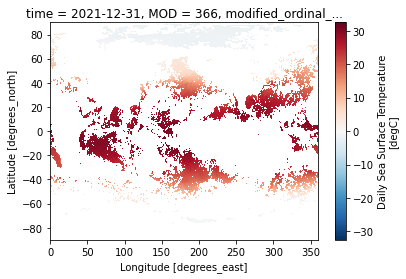

In [22]:
# Check it out
hot_water.isel(time = -1).sst.plot()

/Users/akemberling/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


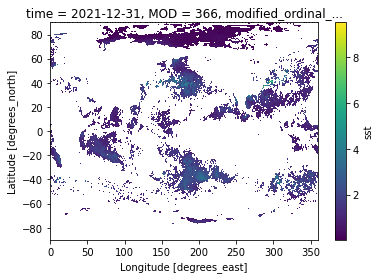

In [27]:
# Plot Anomalies that day
hot_anoms.isel(time = -1).sst.plot()

# Save HW History

Each year's heatwave events have now been processed, we can export what these are as its own gridded dataset.

In [ ]:
# Join back to the climatology so all of that is in one spot

In [ ]:
# Flag events somehow using the actual observation datasets

In [ ]:
# Track their durations?

In [ ]:
# Check for breaks that aren't 2+ days

In [ ]:
# Do some summary stats

In [ ]:
# Use ocetrac to spatially track them